In [1]:
# %pip install langchain-text-splitters langchain-community sentence-transformers pypdf langchain-qdrant

In [2]:
# %pip install pdf2image qdrant-client pillow

In [3]:
# %pip install pymupdf pillow

In [1]:
# Imports
import os, fitz
from PIL import Image
from typing import List, Any, Dict
import matplotlib.pyplot as plt

from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [2]:
#  CONFIG 
PDF_PATH = "Dataset/QwenVL2.5.pdf"
STORAGE_PATH = "qdrant_storage"
COLLECTION_NAME = "pdf_rag"
os.makedirs(STORAGE_PATH, exist_ok=True)

#  LOAD & SPLIT 
loader = PyPDFLoader(PDF_PATH)
documents: List[Document] = loader.load()

# Fix page numbers (PyPDFLoader already adds 'page', but let's ensure 1-based)
for i, doc in enumerate(documents):
    if "page" not in doc.metadata:
        doc.metadata["page"] = i + 1
    else:
        doc.metadata["page"] = doc.metadata["page"] + 1  # PyPDFLoader uses 0-based

splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=50)
docs = splitter.split_documents(documents)

#  EMBEDDINGS 
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

#  QDRANT CLIENT (DISK) 
client = QdrantClient(path=STORAGE_PATH)

#  CREATE COLLECTION IF NOT EXISTS 
if not client.collection_exists(COLLECTION_NAME):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

#  QDRANT VECTOR STORE WITH PAYLOAD KEYS 
vector_store = QdrantVectorStore(
    client=client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings,
    content_payload_key="text",        # <--- Store page_content here
    metadata_payload_key="metadata"    # <--- Store metadata (incl. page) here
)

# ADD DOCUMENTS (THIS STORES TEXT + METADATA)
vector_store.add_documents(docs)

print(f"Indexed {len(docs)} chunks with page metadata.")

C:\Users\User\AppData\Local\Temp\ipykernel_23224\2268417748.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Indexed 455 chunks with page metadata.


In [3]:
def query_with_page(query: str, k: int = 3) -> List[Dict[str, Any]]:
    query_vector = embeddings.embed_query(query)

    search_results = client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_vector,
        limit=k,
        with_payload=True,
        with_vectors=True  # This gives us the stored embedding
    )

    results = []
    print(f"\nQuery: '{query}'\n" + "="*60)
    
    for i, hit in enumerate(search_results, 1):
        payload = hit.payload or {}
        metadata = payload.get("metadata", {}) or {}
        
        result = {
            "rank": i,
            "text": payload.get("text", ""),
            "page": metadata.get("page", "Unknown"),
            "score": hit.score,
            "embedding": hit.vector  # Full 384-dim vector as list
        }
        results.append(result)

        # Pretty print
        text_snippet = result["text"][:300] + "..." if len(result["text"]) > 300 else result["text"]
        emb_preview = result["embedding"][:5] if isinstance(result["embedding"], list) else result["embedding"][:5].tolist()

        print(f"Result {i} | Page: {result['page']} | Score: {result['score']:.4f}")
        print(f"Text: {text_snippet}")
        print(f"Embedding[:5]: {emb_preview}\n")

    return results  # Return structured data

In [4]:
# Run query
results = query_with_page("What is Native Dynamic Resolution and Frame Rate", k=3)

print('Count of related  embeddings: ', len(results))

# Access data programmatically
for res in results:
    print(f"Page {res['page']}: {res['text'][:100]}...")
    print(f"Embedding shape: {len(res['embedding'])}")  # Should be 384

filtered_list = []
seen_pages = set()

for res in results:
    page = res.get("page")
    if isinstance(page, int) and page > 0 and page not in seen_pages:
        seen_pages.add(page)
        filtered_list.append(res)


Query: 'What is Native Dynamic Resolution and Frame Rate'
Result 1 | Page: 3 | Score: 0.6205
Text: designed to handle inputs at their native resolution and supports dynamic FPS sampling. Images of
varying sizes and video frames with different FPS rates are dynamically mapped to token sequences
Embedding[:5]: [0.021542900599863038, -0.019068788229536955, -0.014945298966852663, -0.08013099218720468, 0.028840880073407845]

Result 2 | Page: 3 | Score: 0.6205
Text: designed to handle inputs at their native resolution and supports dynamic FPS sampling. Images of
varying sizes and video frames with different FPS rates are dynamically mapped to token sequences
Embedding[:5]: [0.021542900599863038, -0.019068788229536955, -0.014945298966852663, -0.08013099218720468, 0.028840880073407845]

Result 3 | Page: 3 | Score: 0.6205
Text: designed to handle inputs at their native resolution and supports dynamic FPS sampling. Images of
varying sizes and video frames with different FPS rates are dynamicall

C:\Users\User\AppData\Local\Temp\ipykernel_23224\2812360581.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


In [5]:
def get_page_images(pdf_path: str, filtered_list: List[Dict[str, Any]], max_pages: int = 3) -> List[Image.Image]:
    if not os.path.exists(pdf_path):
        print(f"[ERROR] PDF not found: {pdf_path}")
        return []

    if not filtered_list:
        return []

    # Limit to max_pages
    filtered_list = filtered_list[:max_pages]

    images = []
    titles = []
    try:
        doc = fitz.open(pdf_path)
        for res in filtered_list:
            page_1b = res["page"]
            page_0b = page_1b - 1
            if page_0b < len(doc):
                pix = doc[page_0b].get_pixmap(dpi=200)
                img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
                images.append(img)
                titles.append(f"Page {page_1b}\nScore: {res.get('score', 0):.3f}")
            else:
                blank = Image.new("RGB", (800, 1000), "lightgray")
                images.append(blank)
                titles.append(f"Page {page_1b}\n(Invalid)")
        doc.close()
    except Exception as e:
        print(f"[PDF→Image] Error: {e}")
        return []

    # Plot
    n = len(images)
    if n > 0:
        cols = min(n, 3)
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 8 * rows))
        axes = axes.flat if hasattr(axes, "flat") else [axes]
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title, fontsize=11, pad=8)
            ax.axis("off")
        for i in range(n, len(axes)):
            axes[i].axis("off")
        plt.tight_layout()
        plt.show()

    return images

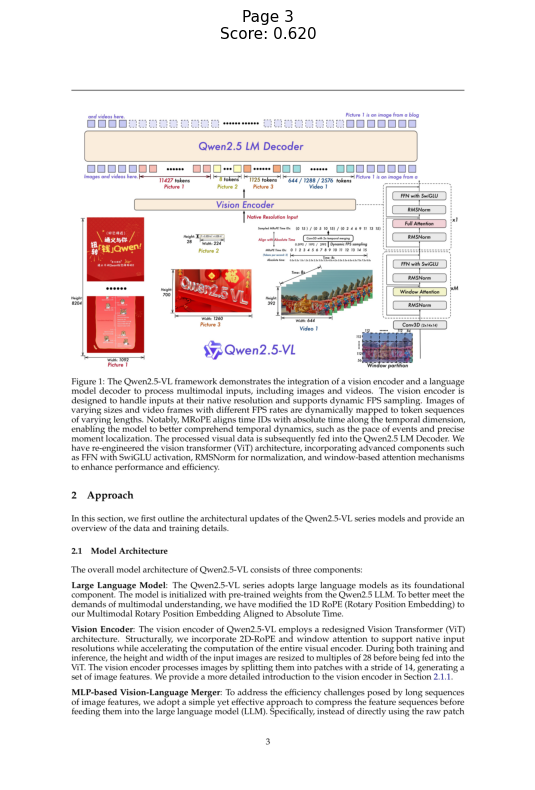

In [6]:
images_extracted = get_page_images('Dataset/QwenVL2.5.pdf', filtered_list, 3)

In [7]:
# Load Qwen VL model
# default: Load the model on the available device(s)
model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-4B-Instruct", 
    dtype="auto", 
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Build Message using RAG pipeline function
# Input Query, Task, Preffered Model, Max Image, PDF Path, KNN) ---> Return chat

In [9]:
# Build chat messages with QUERY + images + embeddings
messages = [
    {
        "role": "user",
        "content": [
            # Add retrieved images
            *[
                {"type": "image", "image": img}  # PIL.Image directly supported
                for img in images_extracted
            ],
            # Add relevant text chunks (from filtered_list)
            *[
                {"type": "text", "text": f"[Page {res['page']}] {res['text']}"}
                for res in filtered_list
            ],
            # Final task
            {
                "type": "text",
                "text": f"Summarize the following content from the document in 3-5 sentences:\n\n" + 
                        "\n\n".join([res['text'] for res in filtered_list])
            }
        ]
    }
]

# Apply chat template and run inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

generated_ids = model.generate(**inputs, max_new_tokens=1668)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

The Qwen2.5-VL framework is designed to process multimodal inputs like images and videos at their native resolutions, with support for dynamic frame rates (FPS). It dynamically maps varying-sized images and video frames with different FPS into token sequences of adjustable lengths. This capability enables the model to better understand temporal dynamics, such as event pacing and precise moment localization, through mechanisms like MRoPE (Multimodal Rotary Position Embedding) aligned with absolute time. The system integrates a vision encoder with advanced components like window attention and SwiGLU activation to enhance both performance and efficiency. This architecture allows for flexible and high-fidelity multimodal understanding across diverse input formats.
